# Target Feature Category Selection & Preliminary Modeling
Select target feature categories to use for classification

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import jenkspy
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from scipy import stats
from scipy.special import boxcox, inv_boxcox

## IMPORT DATA

In [2]:
# import modeling dataset
df = pd.read_csv('02.data/exec_dir/model_dataset_features_eng.csv')

In [3]:
df.head()

,pca_voting_members,pca_1_financial,pca_2_financial,pca_3_financial,pca_states_pos_1,pca_states_pos_2,reportable_comp,formation_yr,state_median_income,ntee_categories,volunteer_tot_ct,ceo_comp_review,officer_comp_review,count_of_controls,gov_cluster_labels,subsection_501(c)(3),subsection_501(c)(6),subsection_501(c)(5),subsection_501(c)(14),subsection_501(c)(4),subsection_501(c)(12),subsection_501(c)(7),pca_states_neg
0,81.836376,-3.093849e+07,-1.949494e+06,680572.434261,-0.088803,-0.074793,198085.0,1995,56277,"Public, Societal Benefit",0,False,False,7,59,False,True,False,False,False,False,False,-0.111428
1,-1.570751,-3.228995e+07,-2.997349e+06,391297.082198,-0.088803,-0.074793,87550.0,1911,56277,"Public, Societal Benefit",100,True,True,10,4,False,True,False,False,False,False,False,-0.111428
2,-5.811792,-3.037481e+07,-3.696782e+06,-270187.080586,-0.088803,-0.074793,64575.0,1896,56277,"Arts, Culture, and Humanities",50,True,True,8,33,True,False,False,False,False,False,False,-0.111428
3,-2.984431,-3.274835e+07,-3.484409e+06,386632.405751,-0.088803,-0.074793,62180.0,1927,56277,"Public, Societal Benefit",4,True,True,9,44,False,True,False,False,False,False,False,-0.111428
4,13.979730,-3.135659e+07,-2.734836e+06,374607.408253,-0.088803,-0.074793,130513.0,1952,56277,"Public, Societal Benefit",145,True,True,12,16,False,True,False,False,False,False,False,-0.111428


In [4]:
# assign X variables
X = pd.get_dummies(df.drop(['reportable_comp'], axis=1))

In [5]:
X.shape

(54814, 31)

### jenkspy - bins set to 10 on boxcox transformed data
Because of how many salaries are at the small end of the spectrum, and how the model seems to do best in that area. I wanted to experiment with transforming the target variable to see how it affected model performance.

In [6]:
stats.boxcox(df.reportable_comp)

(array([1.56433319, 1.56389107, 1.56365756, ..., 1.56430247, 1.56413175,
        1.56400234]), -0.6389863384132674)

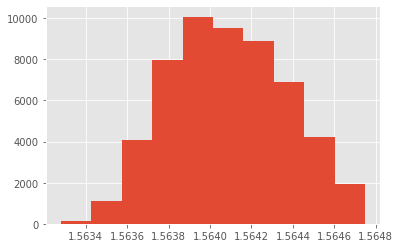

In [7]:
pd.Series(stats.boxcox(df.reportable_comp)[0]).hist()

The salary range looks normally distributed now.

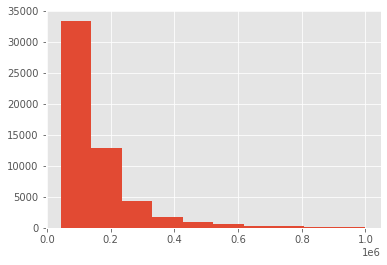

In [8]:
df.reportable_comp.hist()

In [9]:
# identify natural breaks using jenks
breaks_box_cox = jenkspy.jenks_breaks(stats.boxcox(df.reportable_comp)[0], nb_class=10)

In [10]:
breaks_box_cox

[1.5632792567743352,
 1.5636153020247758,
 1.5637436226300423,
 1.5638559775358167,
 1.5639620332430098,
 1.5640680388449337,
 1.5641769212240526,
 1.564289231735916,
 1.5644104803927659,
 1.5645525605392214,
 1.5647492154761438]

In [11]:
len(breaks_box_cox)

11

In [12]:
# get the inverse of box-cox 
# to see the levels of the classification
list(inv_boxcox(breaks_box_cox, stats.boxcox(df.reportable_comp)[1]))

[43542.99999999982,
 61470.00000000355,
 71754.00000000097,
 83304.99999999095,
 97300.00000000003,
 115599.0000000083,
 141092.00000002203,
 178678.99999995358,
 241841.99999996755,
 379405.999999752,
 999511.000000438]

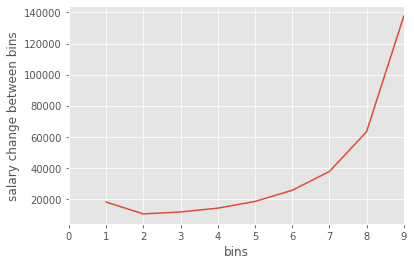

In [13]:
pd.DataFrame(list(inv_boxcox(breaks_box_cox, stats.boxcox(df.reportable_comp)[1]))).diff().iloc[:-1,].plot(legend=False)
plt.xlabel('bins')
plt.ylabel('salary change between bins');

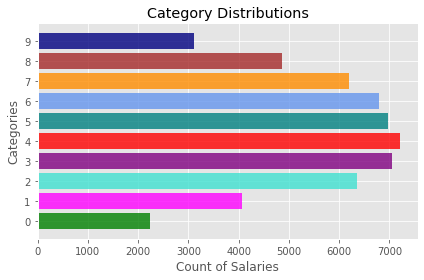

In [39]:
fig, ax = plt.subplots(figsize=(6, 4))
from itertools import cycle

colors = ['navy', 
        'brown', 
        'darkorange', 
        'cornflowerblue', 
        'teal',
        'red',
       'purple',
       'turquoise',
       'magenta',
       'green']

for i, cat, color in zip([x for x in range(0, 10)],
                      pd.cut(pd.Series(stats.boxcox(df.reportable_comp)[0]),
        bins=breaks_box_cox,
        include_lowest=True).cat.codes.value_counts().sort_index().values, 
                      list(reversed(colors))):
    plt.barh(width=cat, y=i, color=color, alpha=.8)

plt.xlabel('Count of Salaries')
plt.yticks([x for x in range(0, 10)])

plt.ylabel('Categories')
plt.title('Category Distributions')
plt.tight_layout()

plt.savefig('exec_director_analysis/category_breaks_dist.png');

Using boxcox, the distribution between categories is a bit more even, neither side has a long tail.

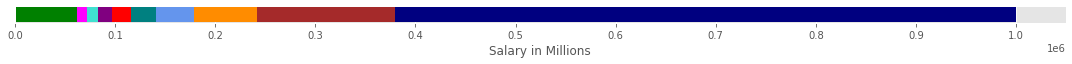

In [38]:
# visualize the jump in salary
# between bin levels
fig, ax = plt.subplots(figsize=(15, 1))
from itertools import cycle

colors = ['navy', 
        'brown', 
        'darkorange', 
        'cornflowerblue', 
        'teal',
        'red',
       'purple',
       'turquoise',
       'magenta',
       'green']

for cat, color in zip(pd.Series(inv_boxcox(breaks_box_cox, stats.boxcox(df.reportable_comp)[1]))[1:] \
    .reset_index(drop=True).sort_index(ascending=False), colors):
    plt.barh(width=cat, y=0, color=color)

ax.axes.get_yaxis().set_visible(False)
plt.xlabel('Salary in Millions')
plt.xticks([x for x in range(0, 1100000, 100000)])
# plt.title('Salary Break Levels')
plt.tight_layout()
plt.savefig('exec_director_analysis/salary_category_schedule.png');

In [16]:
[x for x in range(0, 10)]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Text(0.5, 1.0, 'Salary Bins Quantities')

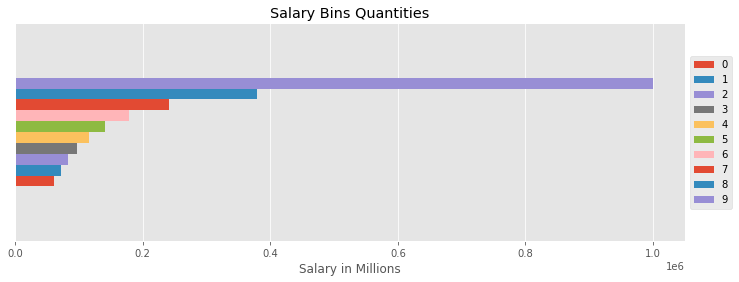

In [17]:
ax = pd.DataFrame(pd.Series(inv_boxcox(breaks_box_cox, stats.boxcox(df.reportable_comp)[1]))[1:].reset_index(drop=True)) \
.T.plot.barh(
figsize=(12, 4))

ax.legend(loc='center left', bbox_to_anchor=(1.0, .5))
ax.axes.get_yaxis().set_visible(False)
plt.xlabel('Salary in Millions')
plt.title('Salary Bins Quantities')
# plt.savefig('03.visualizations/salary_category_schedule.png');

### Preliminary modeling to see if these bins improve classification results

In [18]:
y = pd.cut(pd.Series(stats.boxcox(df.reportable_comp)[0]),
        bins=breaks_box_cox,
        include_lowest=True).cat.codes

In [19]:
X.head()

,pca_voting_members,pca_1_financial,pca_2_financial,pca_3_financial,pca_states_pos_1,pca_states_pos_2,formation_yr,state_median_income,volunteer_tot_ct,ceo_comp_review,officer_comp_review,count_of_controls,gov_cluster_labels,subsection_501(c)(3),subsection_501(c)(6),subsection_501(c)(5),subsection_501(c)(14),subsection_501(c)(4),subsection_501(c)(12),subsection_501(c)(7),pca_states_neg,"ntee_categories_Arts, Culture, and Humanities",ntee_categories_Education,ntee_categories_Environment and Animals,ntee_categories_Health,ntee_categories_Human Services,"ntee_categories_International, Foreign Affairs",ntee_categories_Mutual/Membership Benefit,"ntee_categories_Public, Societal Benefit",ntee_categories_Religion Related,"ntee_categories_Unknown, Unclassified"
0,81.836376,-3.093849e+07,-1.949494e+06,680572.434261,-0.088803,-0.074793,1995,56277,0,False,False,7,59,False,True,False,False,False,False,False,-0.111428,0,0,0,0,0,0,0,1,0,0
1,-1.570751,-3.228995e+07,-2.997349e+06,391297.082198,-0.088803,-0.074793,1911,56277,100,True,True,10,4,False,True,False,False,False,False,False,-0.111428,0,0,0,0,0,0,0,1,0,0
2,-5.811792,-3.037481e+07,-3.696782e+06,-270187.080586,-0.088803,-0.074793,1896,56277,50,True,True,8,33,True,False,False,False,False,False,False,-0.111428,1,0,0,0,0,0,0,0,0,0
3,-2.984431,-3.274835e+07,-3.484409e+06,386632.405751,-0.088803,-0.074793,1927,56277,4,True,True,9,44,False,True,False,False,False,False,False,-0.111428,0,0,0,0,0,0,0,1,0,0
4,13.979730,-3.135659e+07,-2.734836e+06,374607.408253,-0.088803,-0.074793,1952,56277,145,True,True,12,16,False,True,False,False,False,False,False,-0.111428,0,0,0,0,0,0,0,1,0,0


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [21]:
rfc = ensemble.RandomForestClassifier()

In [22]:
rfc.fit(X_train, y_train)

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [23]:
# predict categores
pred = rfc.predict(X_test)

In [34]:
rfc.score(X_train, y_train)

0.9218717931176028

In [35]:
rfc.score(X_test, y_test)

0.24363769041320807

In [25]:
# create confusion matrix and
# normalize the matrix to more accurately 
# compare which predictions the model is getting wrong
norm_conf_matrix = confusion_matrix(y_test, pred) / \
confusion_matrix(y_test, pred).sum(axis=1, keepdims=True)

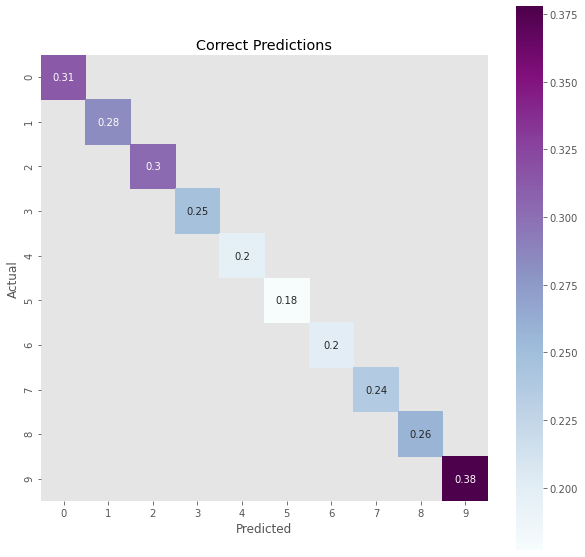

In [26]:
# display only the diagonal values
# representing values the model correctly predicted
plt.figure(figsize=(10, 10))

sns.heatmap(np.where(np.diagflat(np.diagonal(norm_conf_matrix))
            ==0, np.nan, np.diagflat(np.diagonal(norm_conf_matrix))),
            cmap='BuPu',
            annot=True,
            square=True,
            );
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Correct Predictions');

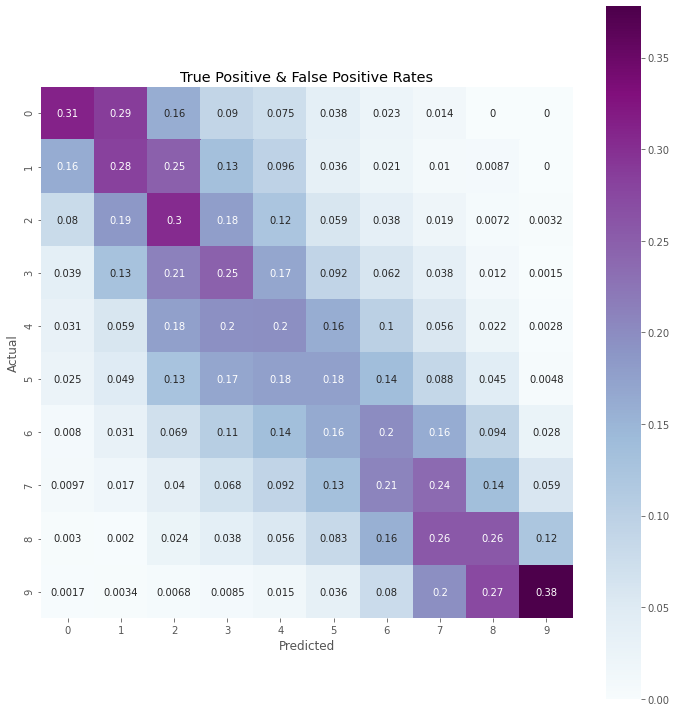

In [37]:
# compare correct and incorrect predictions
plt.figure(figsize=(10, 10))
# np.fill_diagonal(norm_conf_matrix, 0)

ax = sns.heatmap(norm_conf_matrix, 
                 square=True, annot=True, 
                 cmap='BuPu')

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('True Positive & False Positive Rates')
plt.tight_layout()
plt.savefig('exec_director_analysis/heat_map_rfc.png');

In [28]:
f_importances = pd.Series(rfc.feature_importances_, 
          X_train.columns).sort_values(ascending=False)

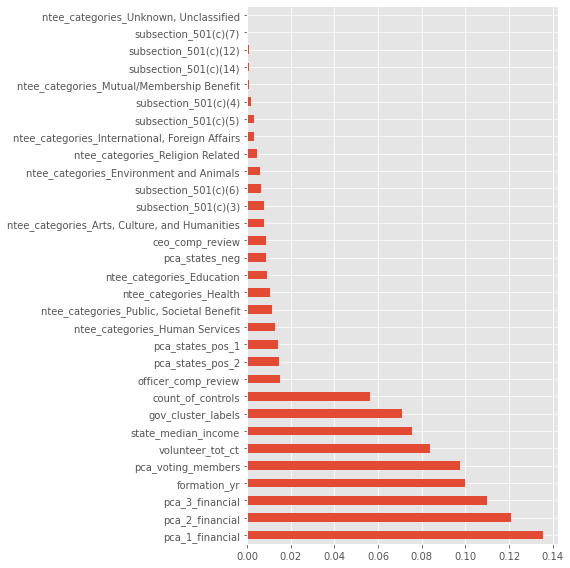

In [29]:
f_importances.plot(kind='barh', figsize=(8, 8))
plt.tight_layout()
# plt.savefig('03.visualizations/rfc_feature_importance.png');

## EXPORT TARGET FEATURE LABEL BINS FOR FURTHER MODELING
Although a higher number of bins hurts my model performance, I feel comfortable that a model with a higher number of bins will allow my model to be more valuable to an end user.  This will also allow me to have more visibility into how best to parameter tune the model.  As a result, I will use 20 bins that I created using jenkspy as my final labels for modeling. 

In [30]:
y.to_csv('02.data/exec_dir/target_categories_box_cox.csv', index=False, header=False)

In [31]:
# export median salary levels for each bin
pd.concat([df.reportable_comp,
           y], axis=1).groupby(0) \
    .median().to_csv('02.data/exec_dir/category_median_salary.csv', index=False, header=True)